# Flat Gaussian with compositional score matching


In this notebook, we will use the compositional score matching to learn the posterior of a flat Gaussian model.
The problem is defined as follows:
- The prior is a Gaussian distribution with mean 0 and standard deviation 0.1.
- The simulator/likelihood is a Gaussian distribution with mean 0 and standard deviation 0.1.
- We have an analytical solution for the posterior.
- We set the dimension of the problem to $D=10$.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from bayesflow import diagnostics
from torch.utils.data import DataLoader

from diffusion_model import CompositionalScoreModel, SDE, weighting_function, train_score_model, euler_maruyama_sampling, adaptive_sampling, probability_ode_solving, langevin_sampling, generate_diffusion_time, count_parameters
from problems.gaussian_flat import GaussianProblem, Prior, Simulator, visualize_simulation_output, generate_synthetic_data, \
    sample_posterior, posterior_contraction, analytical_posterior_median

/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
torch_device = torch.device("cpu")

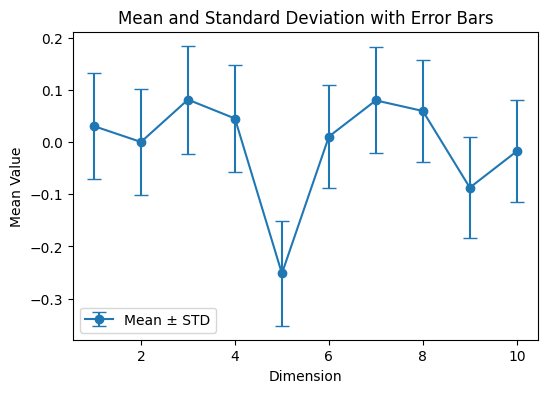

In [3]:
prior = Prior()
simulator_test = Simulator()

# test the simulator
prior_test = prior.sample(2)
sim_test = simulator_test(prior_test, n_obs=1000)
visualize_simulation_output(sim_test['observable'])

In [4]:
batch_size = 128
max_number_of_obs = 100  # larger than one means we condition the score on multiple observations

dataset = GaussianProblem(
    n_data=10000,
    prior=prior,
    online_learning=True,
    max_number_of_obs=max_number_of_obs
)
dataset_valid = GaussianProblem(
    n_data=batch_size*2,
    prior=prior,
    max_number_of_obs=max_number_of_obs
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [5]:
# Define diffusion model
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][0]
)

score_model = CompositionalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_x=prior.D,
    hidden_dim=64,
    n_blocks=3,
    max_number_of_obs=max_number_of_obs,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    time_embed_dim=16,
    use_film=False,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior
)
#score_model.name = score_model.name + '_same_sim_budget'
count_parameters(score_model)
print(score_model.name)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

+------------------------------------+------------+
|              Modules               | Parameters |
+------------------------------------+------------+
|    summary_net.module.0.weight     |    640     |
|     summary_net.module.0.bias      |     64     |
|     global_model.embed.0.scale     |     1      |
|    global_model.embed.1.weight     |    256     |
|     global_model.embed.1.bias      |     16     |
|  global_model.input_layer.weight   |    640     |
|   global_model.input_layer.bias    |     64     |
|  global_model.blocks.0.fc1.weight  |   13376    |
|   global_model.blocks.0.fc1.bias   |     64     |
| global_model.blocks.0.norm1.weight |     64     |
|  global_model.blocks.0.norm1.bias  |     64     |
|  global_model.blocks.0.fc2.weight  |   13376    |
|   global_model.blocks.0.fc2.bias   |     64     |
| global_model.blocks.0.norm2.weight |     64     |
|  global_model.blocks.0.norm2.bias  |     64     |
|  global_model.blocks.1.fc1.weight  |   13376    |
|   global_m

In [ ]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 epochs=500, lr=1e-3, cosine_annealing=True, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Mean Train')
plt.plot(loss_history[:, 1], label='Mean Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')
plt.show()

In [6]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", weights_only=True))
score_model.eval();

## Visualize Loss

In [ ]:
# check the error prediction: is it close to the noise?
loss_list_target = {}
loss_list_score = {}
loss_list_error_w_global = {}
loss_list_error = {}

with torch.no_grad():
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=100, device=torch_device)
    for t in diffusion_time:
        loss_list_target[t.item()] = 0
        loss_list_score[t.item()] = 0
        loss_list_error_w_global[t.item()] = 0
        loss_list_error[t.item()] = 0

        for theta_global_batch, _, x_batch in dataloader_valid:
            theta_global_batch = theta_global_batch.to(torch_device)
            x_batch = x_batch.to(torch_device)

            # sample from the Gaussian kernel, just learn the noise
            epsilon_global = torch.randn_like(theta_global_batch, dtype=torch.float32, device=torch_device)

            # perturb the theta batch
            t_tensor = torch.full((theta_global_batch.shape[0], 1), t,
                                  dtype=torch.float32, device=torch_device)
            # perturb the theta batch
            alpha, sigma = score_model.sde.kernel(t=t_tensor)
            snr = torch.log(torch.square(alpha)) - torch.log(torch.square(sigma))
            z_global = alpha * theta_global_batch + sigma * epsilon_global

            # predict from perturbed theta
            pred_epsilon_global = score_model(theta_global=z_global, time=t_tensor, x=x_batch, pred_score=False)
            pred_score_global = score_model(theta_global=z_global, time=t_tensor, x=x_batch, pred_score=True)
            true_score_global = score_model.sde.grad_log_kernel(x=z_global,
                                                                x0=theta_global_batch, t=t_tensor)

            if score_model.prediction_type == 'score':
                target_global = -epsilon_global / sigma
                pred_target_global = -pred_epsilon_global / sigma
            elif score_model.prediction_type == 'e':
                target_global = epsilon_global
                pred_target_global = pred_epsilon_global
            elif score_model.prediction_type == 'v':
                target_global = alpha*epsilon_global - sigma * theta_global_batch
                pred_target_global = alpha*pred_epsilon_global - sigma * theta_global_batch
            elif score_model.prediction_type == 'x':
                target_global = theta_global_batch
                pred_target_global = (z_global - pred_epsilon_global * sigma) / alpha
            else:
                raise ValueError("Invalid prediction type.")

            # calculate the loss (sum over the last dimension, mean over the batch)
            loss_global = torch.mean(torch.sum(torch.square(pred_target_global - target_global), dim=-1))
            loss = loss_global
            loss_list_target[t.item()] += loss.item()

            # calculate the error of the true score
            loss_global = torch.mean(torch.sum(torch.square(pred_score_global - true_score_global), dim=-1))
            loss = loss_global
            loss_list_score[t.item()] += loss.item()

            # calculate the weighted loss
            w = weighting_function(t_tensor, sde=score_model.sde,
                                   weighting_type=score_model.weighting_type, prediction_type=score_model.prediction_type)
            loss_global = torch.mean(w * torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss_list_error_w_global[t.item()] += loss_global.item()

            # check if the weighting function is correct
            loss_global = torch.mean(torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss = loss_global
            loss_list_error[t.item()] += loss.item()

In [ ]:
df_target = pd.DataFrame(loss_list_target.items(), columns=['Time', 'Loss'])
df_score = pd.DataFrame(loss_list_score.items(), columns=['Time', 'Loss'])
df_error_w_global = pd.DataFrame(loss_list_error_w_global.items(), columns=['Time', 'Loss'])
df_error = pd.DataFrame(loss_list_error.items(), columns=['Time', 'Loss'])

# compute snr
snr = score_model.sde.get_snr(diffusion_time)
#upper_bound_loss = (np.sqrt(2) + 1) / (std.numpy()**2)

fig, ax = plt.subplots(ncols=4, sharex=True, figsize=(16, 3), tight_layout=True)
ax[0].plot(df_target['Time'], np.log(df_target['Loss']), label=f'Unscaled {score_model.prediction_type} Loss')
ax[1].plot(df_score['Time'], np.log(df_score['Loss']), label='Score Loss')
#ax[1].plot(df_score['Time'], df_score['Loss'] / upper_bound_loss, label='Score Loss')
ax[1].plot(diffusion_time, snr, label='log snr', alpha=0.5)
ax[2].plot(df_error_w_global['Time'], np.log(df_error_w_global['Loss']), label='Weighted Loss (as in Optimization)')
ax[3].plot(df_error['Time'], np.log(df_error['Loss']), label='Loss on Error')
for a in ax:
    a.set_xlabel('Diffusion Time')
    a.set_ylabel('Log Loss')
    a.legend()
plt.savefig(f'plots/{score_model.name}/losses_diffusion_time.png')
plt.show()

plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(diffusion_time.cpu(),
         weighting_function(diffusion_time, sde=score_model.sde, weighting_type=score_model.weighting_type,
                            prediction_type=score_model.prediction_type).cpu(),
         label='weighting')
plt.xlabel('Diffusion Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Validation

In [ ]:
data_size = 10  # number of observations
valid_prior_global, valid_data = generate_synthetic_data(prior, n_samples=100, data_size=data_size,
                                                         normalize=False, random_seed=0)
param_names = ['$D_{' + str(i+1) + '}$' for i in range(prior.D)]
n_post_samples = 100
score_model.current_number_of_obs = 1

In [ ]:
visualize_simulation_output(valid_data)

In [ ]:
sample_posterior_single = lambda vd: sample_posterior(
    vd,
    prior_sigma=prior.scale,
    sigma=prior.simulator.scale,
    n_samples=n_post_samples
)
posterior_global_samples_true = np.array([sample_posterior_single(vd) for vd in valid_data])

In [ ]:
diagnostics.plot_recovery(posterior_global_samples_true, np.array(valid_prior_global), param_names=param_names)
diagnostics.plot_sbc_ecdf(posterior_global_samples_true, np.array(valid_prior_global),
                          difference=True, param_names=param_names);

In [ ]:
posterior_global_samples_valid = np.array([langevin_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                             #n_scores_update=10,
                                                            diffusion_steps=300, langevin_steps=5, step_size_factor=0.05,
                                           device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_langevin_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_langevin_sampler{score_model.current_number_of_obs}.png')

In [ ]:
posterior_global_samples_valid = np.array([euler_maruyama_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                                   #n_scores_update=10,
                                                                   diffusion_steps=1500, device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sampler{score_model.current_number_of_obs}.png')

In [ ]:
posterior_global_samples_valid = np.array([euler_maruyama_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                                   n_scores_update=10,
                                                                   diffusion_steps=300, device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sub_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sub_sampler{score_model.current_number_of_obs}.png')

In [ ]:
posterior_global_samples_valid = np.zeros((len(valid_data), n_post_samples, prior.D))
for i, vd in enumerate(valid_data):
    # solve for every sample individually, much slower, and still most of the samples were similar
    #for j in range(n_post_samples):
    #   posterior_global_samples_valid[i, j] = adaptive_sampling(score_model, vd, n_post_samples=1, device=torch_device)
    # solve for all samples at once
    posterior_global_samples_valid[i] = adaptive_sampling(score_model, vd, n_post_samples=n_post_samples, device=torch_device)

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_adaptive_sampler{score_model.current_number_of_obs}.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                                difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_adaptive_sampler{score_model.current_number_of_obs}.png')

In [ ]:
posterior_global_samples_valid = np.zeros((len(valid_data), n_post_samples, prior.D))
for i, vd in enumerate(valid_data):
    # solve for every sample individually, much slower, and still most of the samples were similar
    for j in range(n_post_samples):
       posterior_global_samples_valid[i, j] = probability_ode_solving(score_model, vd, n_post_samples=1, device=torch_device)
    # solve for all samples at once
    #posterior_global_samples_valid[i] = probability_ode_solving(score_model, vd, n_post_samples=n_post_samples, device=torch_device)

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_ode{score_model.current_number_of_obs}.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_ode{score_model.current_number_of_obs}.png')

# Step Size for different Grid Sizes

- we compare score model with only one condition, and with $k$-conditions
- we show that the scaling in the number of needed sampling steps only depends on the Bayesian Units used
- error reduces when using more conditions, but since network size stays the same, increases at some point again
- we show how mini batching effects the posterior

Metrics:
- MMD between true and estimated posterior samples
- RMSE between the medians of true and estimated posterior samples
- Posterior contraction: (1 - var_empirical_posterior / var_prior) / (1 - var_true_posterior / var_prior), and using the mean variances over all parameters

In [7]:
def gaussian_kernel(x, y, sigma):
    """Compute Gaussian kernel between two sets of samples."""
    x = np.atleast_2d(x)
    y = np.atleast_2d(y)
    sq_dists = np.sum((x[:, None, :] - y[None, :, :]) ** 2, axis=2)
    return np.exp(-sq_dists / (2 * sigma ** 2))

def compute_mmd(x, y, sigma=1.0):
    """
    Compute the Maximum Mean Discrepancy (MMD) between two sets of samples.

    Args:
        x (np.ndarray): Samples from distribution P, shape (n, d).
        y (np.ndarray): Samples from distribution Q, shape (m, d).
        sigma (float): Bandwidth for the Gaussian kernel.

    Returns:
        float: Estimated MMD^2 value.
    """
    x = np.asarray(x)
    y = np.asarray(y)

    # Compute kernel matrices
    K_xx = gaussian_kernel(x, x, sigma)
    K_yy = gaussian_kernel(y, y, sigma)
    K_xy = gaussian_kernel(x, y, sigma)

    # Compute MMD^2
    mmd_squared = (np.mean(K_xx) + np.mean(K_yy) - 2 * np.mean(K_xy))
    return mmd_squared

In [8]:
# Ensure we generate enough synthetic data samples.
n_samples_data = 2
n_post_samples = 100
score_model.current_number_of_obs = 1
max_steps = 5000

# Set up your data sizes and mini-batch parameters.
data_sizes = np.array([1, 10, 100, 1000])
mini_batch = [1, 10, 100, 1000, None]

# List to store results.
results = []

# Iterate over data sizes.
for n in data_sizes:
    # Generate synthetic data with enough samples
    true_params, test_data = generate_synthetic_data(prior, n_samples=n_samples_data, data_size=n,
                                                      normalize=False, random_seed=0)
    # Iterate over each valid id.
    for data_id in range(n_samples_data):
        x_test = test_data[data_id].to(torch_device)
        # Iterate over mini-batch settings.
        for n_scores in mini_batch:
            # Skip mini-batch settings that are larger than or equal to the data size.
            if n_scores is not None and n_scores >= n:
                continue

            # Run adaptive sampling.
            test_samples, list_steps = adaptive_sampling(score_model, x_test, conditions=None,
                                                         n_post_samples=n_post_samples, n_scores_update=n_scores,
                                                         max_steps=max_steps,
                                                         t_end=0, random_seed=0, device=torch_device,
                                                         return_steps=True)
            # Sample the true posterior.
            true_samples = sample_posterior(x_test, prior_sigma=prior.scale,
                                            sigma=prior.simulator.scale, n_samples=n_post_samples)
            # Compute metrics.
            mmd = compute_mmd(test_samples, true_samples)

            median_error = np.median(test_samples, axis=0) - analytical_posterior_median(x_test, prior_std=prior.scale,
                                                                                         likelihood_std=prior.simulator.scale)
            rmse = np.sqrt(np.mean(median_error**2))

            contractions = 1 - np.var(test_samples, axis=0) / (prior.scale**2)
            true_contraction = posterior_contraction(prior.scale, prior.simulator.scale, n)
            rel_contraction = (contractions / true_contraction).mean()

            # Print current metrics.
            print(f"Data Size: {n}, Data ID: {data_id}, Mini Batch: {n_scores}, "
                  f"MMD: {mmd}, Median RMSE: {rmse}, Contraction: {rel_contraction}")

            # Save results into a dictionary.
            results.append({
                "data_size": n,
                "data_id": data_id,
                "mini_batch": n_scores if n_scores is not None else n,
                "n_steps": len(list_steps),
                "list_steps": np.array(list_steps),
                "mmd": mmd,
                "median": np.median(test_samples, axis=0),
                "median_rmse": rmse,
                "contractions": contractions,
                "rel_contraction": rel_contraction
            })

# Create a DataFrame from the results list.
df_results = pd.DataFrame(results)
df_results.to_csv(f'plots/{score_model.name}/df_results.csv')

Data Size: 1, Data ID: 0, Mini Batch: None, MMD: 0.021515182394268306, Median RMSE: 0.054494580926405, Contraction: 0.6466116178780796
Data Size: 1, Data ID: 1, Mini Batch: None, MMD: 0.006491124279838445, Median RMSE: 0.028179834657228404, Contraction: 0.5903326701372864
Data Size: 10, Data ID: 0, Mini Batch: 1, MMD: 0.033975317357108015, Median RMSE: 0.059395202281478605, Contraction: 0.061088752839714475
Data Size: 10, Data ID: 0, Mini Batch: None, MMD: 0.08357659093775016, Median RMSE: 0.09259648823084816, Contraction: 0.9939998653368093
Data Size: 10, Data ID: 1, Mini Batch: 1, MMD: 0.019992181392276986, Median RMSE: 0.042482006719846824, Contraction: 0.22077805725857638
Data Size: 10, Data ID: 1, Mini Batch: None, MMD: 0.04827133405885742, Median RMSE: 0.07078244077718669, Contraction: 0.9922627686697524
Data Size: 100, Data ID: 0, Mini Batch: 1, MMD: 0.05391236501209429, Median RMSE: 0.0712444169858865, Contraction: 0.16676338239572958
Data Size: 100, Data ID: 0, Mini Batch: 10,

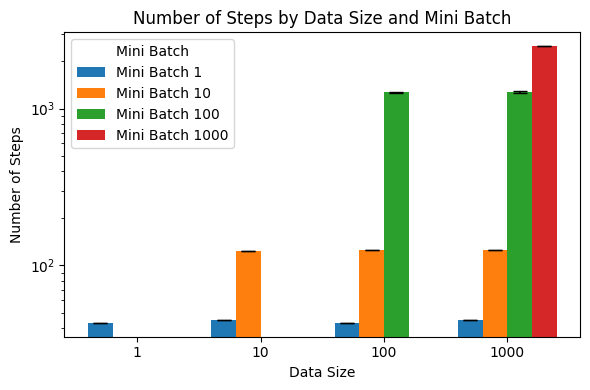

In [9]:
# Group by both data_size and mini_batch to compute mean and standard deviation of n_steps.
grouped_bar = df_results.groupby(['data_size', 'mini_batch'])['n_steps'].agg(['mean','std']).reset_index()

# Determine unique data sizes and mini_batch values.
data_sizes = sorted(grouped_bar['data_size'].unique())
# Order mini_batch values
mini_batch_values = sorted(grouped_bar['mini_batch'].unique())

# Set up bar plot parameters.
n_groups = len(data_sizes)
n_bars = len(mini_batch_values)
bar_width = 0.8 / n_bars  # total width is 0.8 for each group
x = np.arange(n_groups)  # x locations for groups

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
# Plot a bar for each mini_batch value within each data_size group.
for i, mb in enumerate(mini_batch_values):
    # Filter the grouped DataFrame for the current mini_batch value.
    subset = grouped_bar[grouped_bar['mini_batch'] == mb]
    means = []
    stds = []
    for ds in data_sizes:
        # Find the row corresponding to this data size and mini_batch.
        row = subset[subset['data_size'] == ds]
        if not row.empty:
            means.append(row['mean'].values[0])
            stds.append(row['std'].values[0])
        else:
            means.append(np.nan)
            stds.append(0)

    # Define label
    label = f'Mini Batch {int(mb)}'
    # Compute positions for the bars.
    positions = x + i * bar_width
    ax.bar(positions, means, width=bar_width, yerr=stds, capsize=5, label=label)

# Set the x-axis ticks and labels so that groups are centered.
ax.set_xticks(x + bar_width*(n_bars-1)/2)
ax.set_xticklabels(data_sizes)
ax.set_xlabel('Data Size')
ax.set_ylabel('Number of Steps')
ax.set_title('Number of Steps by Data Size and Mini Batch')
#ax.set_yscale('log')
ax.legend(title='Mini Batch')
plt.show()

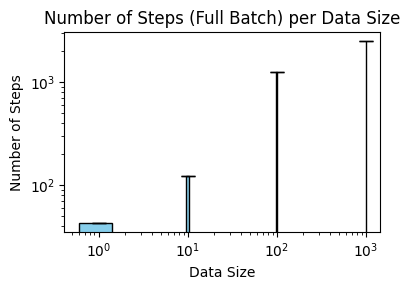

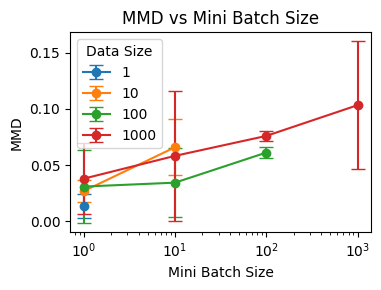

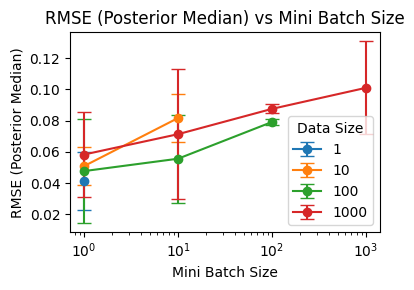

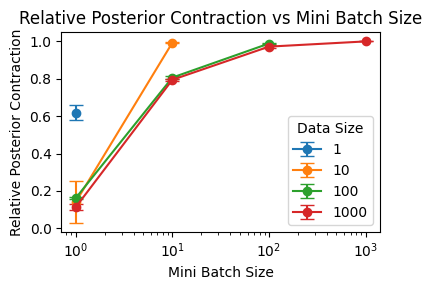

In [17]:
# ------------------------------
# Plot 1: Bar plot of n_steps for the full-batch  case.
# ------------------------------

# Filter the full-batch rows
df_full = df_results[df_results['data_size'] == df_results['mini_batch']]

# Group by data_size and compute mean and standard deviation of n_steps.
grouped_full = df_full.groupby('data_size')['n_steps'].agg(['mean', 'std']).reset_index()

plt.figure(figsize=(4, 3), tight_layout=True)
plt.bar(grouped_full['data_size'], grouped_full['mean'],
        yerr=grouped_full['std'], capsize=5, color='skyblue', edgecolor='black')
plt.xlabel('Data Size')
plt.ylabel('Number of Steps')
plt.title('Number of Steps (Full Batch) per Data Size')
plt.xticks(grouped_full['data_size'])
plt.yscale('log')
plt.xscale('log')
plt.show()

# ------------------------------
# Plot 2: Errorbar plots for MMD, RMSE, and Contraction vs. mini batch size.
# ------------------------------

# Filter rows with a mini_batch value (skip full-batch rows).
df_mb = df_results[df_results['mini_batch'].notnull()].copy()
# Convert mini_batch to float (if not already) to allow proper plotting on the x-axis.
df_mb['mini_batch'] = df_mb['mini_batch'].astype(float)

# Define the metrics to plot: key is dataframe column, value is label for y-axis.
metrics = {
    'mmd': 'MMD',
    'median_rmse': 'RMSE (Posterior Median)',
    'rel_contraction': 'Relative Posterior Contraction'
}

# Identify the unique data sizes (to plot different lines per data size).
unique_data_sizes = sorted(df_mb['data_size'].unique())

# Create one figure per metric.
for metric, metric_label in metrics.items():
    plt.figure(figsize=(4, 3), tight_layout=True)
    for ds in unique_data_sizes:
        # Select the rows for this particular data size.
        df_sub = df_mb[df_mb['data_size'] == ds]
        # Group by mini_batch size to get mean and std of the metric.
        grouped = df_sub.groupby('mini_batch')[metric].agg(['mean', 'std']).reset_index()
        plt.errorbar(grouped['mini_batch'], grouped['mean'], yerr=grouped['std'],
                     marker='o', capsize=5, label=f'{ds}')
    plt.xlabel('Mini Batch Size')
    plt.ylabel(metric_label)
    plt.title(f'{metric_label} vs Mini Batch Size')
    plt.legend(title='Data Size')
    # Using a logarithmic scale for the x-axis since mini-batch sizes vary widely.
    plt.xscale('log')
    plt.show()

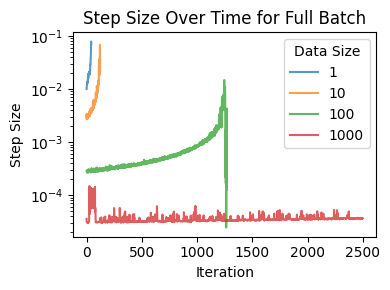

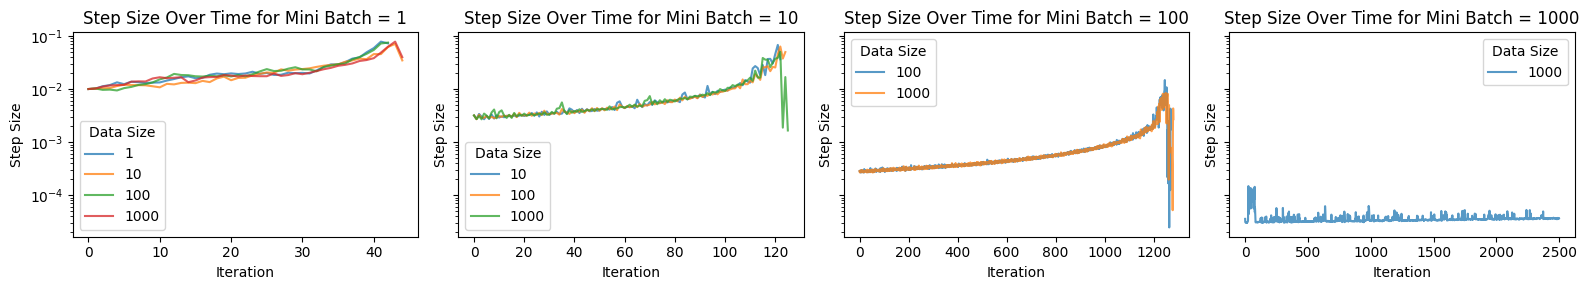

In [20]:
# Figure 1: Full Batch (mini_batch is None) for data_id 0
# ------------------------------
# Filter for valid_id 0 and full-batch runs
df_full = df_results[(df_results['data_id'] == 0) & (df_results['data_size'] == df_results['mini_batch'])]

plt.figure(figsize=(4, 3), tight_layout=True)
for ds in sorted(df_full['data_size'].unique()):
    # Extract the row for this data_size (should be a single row per combination)
    row = df_full[df_full['data_size'] == ds]
    if not row.empty:
        # Extract the list of step sizes (assumed to be a list or array)
        steps_list = row.iloc[0]['list_steps']
        # Plot step size vs iteration
        plt.plot(range(len(steps_list)), steps_list, label=f"{ds}", alpha=.75)

plt.xlabel("Iteration")
plt.ylabel("Step Size")
plt.yscale('log')
plt.title("Step Size Over Time for Full Batch")
plt.legend(title="Data Size")
plt.show()

# ------------------------------
# Figure 2: Mini Batching (mini_batch is not None) for data_id 0
# ------------------------------
# Filter for data_id 0 and only mini-batch runs.
df_mb = df_results[(df_results['data_id'] == 0) & (df_results['mini_batch'].notnull())]

# Get the sorted unique mini_batch values
mini_batch_values = sorted(df_mb['mini_batch'].unique())
n_subplots = len(mini_batch_values)

# Create subplots (one per mini_batch value)
fig, axes = plt.subplots(1, n_subplots, figsize=(4 * n_subplots, 3), sharey=True, tight_layout=True)

# In case there's only one subplot, wrap axes in a list for uniformity.
if n_subplots == 1:
    axes = [axes]

for ax, mb in zip(axes, mini_batch_values):
    # Filter for the current mini_batch value
    df_mb_subset = df_mb[df_mb['mini_batch'] == mb]
    for ds in sorted(df_mb_subset['data_size'].unique()):
        row = df_mb_subset[df_mb_subset['data_size'] == ds]
        if not row.empty:
            steps_list = row.iloc[0]['list_steps']
            ax.plot(range(len(steps_list)), steps_list, label=f"{ds}", alpha=.75)

    ax.set_title(f"Step Size Over Time for Mini Batch = {mb}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Step Size")
    ax.set_yscale('log')
    ax.legend(title="Data Size")
plt.show()

In [21]:
# Set up your data sizes and mini-batch parameters.
data_sizes = np.array([1, 10, 100, 1000])
n_conditions = [1, 5, 10, 20, 50, 100]

# List to store results.
results = []

# Iterate over data sizes.
for n in data_sizes:
    # Generate synthetic data with enough samples
    true_params, test_data = generate_synthetic_data(prior, n_samples=n_samples_data, data_size=n,
                                                      normalize=False, random_seed=0)
    # Iterate over each valid id.
    for data_id in range(n_samples_data):
        x_test = test_data[data_id].to(torch_device)
        # Iterate over number of conditions
        for current_number_of_obs in n_conditions:
            if current_number_of_obs > n:
                continue
            score_model.current_number_of_obs = current_number_of_obs

            # Run adaptive sampling.
            test_samples, list_steps = adaptive_sampling(score_model, x_test, conditions=None,
                                                         n_post_samples=n_post_samples, n_scores_update=None,
                                                         max_steps=max_steps,
                                                         t_end=0, random_seed=0, device=torch_device,
                                                         return_steps=True)
            # Sample the true posterior.
            true_samples = sample_posterior(x_test, prior_sigma=prior.scale,
                                            sigma=prior.simulator.scale, n_samples=n_post_samples)
            # Compute metrics.
            mmd = compute_mmd(test_samples, true_samples)

            median_error = np.median(test_samples, axis=0) - analytical_posterior_median(x_test, prior_std=prior.scale,
                                                                                         likelihood_std=prior.simulator.scale)
            rmse = np.sqrt(np.mean(median_error**2))

            contractions = 1 - np.var(test_samples, axis=0) / (prior.scale**2)
            true_contraction = posterior_contraction(prior.scale, prior.simulator.scale, n)
            rel_contraction = (contractions / true_contraction).mean()

            # Print current metrics.
            print(f"Data Size: {n}, Data ID: {data_id}, #Conditions: {current_number_of_obs}, "
                  f"MMD: {mmd}, Median RMSE: {rmse}, Contraction: {rel_contraction}")

            # Save results into a dictionary.
            results.append({
                "data_size": n,
                "data_id": data_id,
                "current_number_of_obs": current_number_of_obs,
                "n_steps": len(list_steps),
                "list_steps": np.array(list_steps),
                "mmd": mmd,
                "median": np.median(test_samples, axis=0),
                "median_rmse": rmse,
                "contractions": contractions,
                "rel_contraction": rel_contraction,
            })

# Create a DataFrame from the results list.
df_results_conditions = pd.DataFrame(results)
df_results_conditions.to_csv(f'plots/{score_model.name}/df_results_conditions.csv')

Data Size: 1, Data ID: 0, #Conditions: 1, MMD: 0.021515182394268306, Median RMSE: 0.054494580926405, Contraction: 0.6466116178780796
Data Size: 1, Data ID: 1, #Conditions: 1, MMD: 0.006491124279838445, Median RMSE: 0.028179834657228404, Contraction: 0.5903326701372864
Data Size: 10, Data ID: 0, #Conditions: 1, MMD: 0.07935822836028894, Median RMSE: 0.09259648823084816, Contraction: 0.9939998653368093
Data Size: 10, Data ID: 0, #Conditions: 5, MMD: 0.049524053377487665, Median RMSE: 0.07327861786933637, Contraction: 0.7818500774679705
Data Size: 10, Data ID: 0, #Conditions: 10, MMD: 0.06210399440793091, Median RMSE: 0.08138045920861625, Contraction: 0.5995218003168702
Data Size: 10, Data ID: 1, #Conditions: 1, MMD: 0.04827133405885742, Median RMSE: 0.07078244077718669, Contraction: 0.9922627686697524
Data Size: 10, Data ID: 1, #Conditions: 5, MMD: 0.04833660232180681, Median RMSE: 0.07197471586552029, Contraction: 0.8173771824454888
Data Size: 10, Data ID: 1, #Conditions: 10, MMD: 0.019

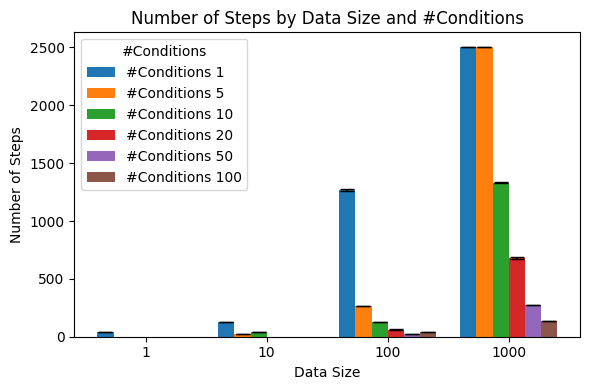

In [38]:
# Group by both data_size and current_number_of_obs to compute mean and standard deviation of n_steps.
grouped_bar = df_results_conditions.groupby(['data_size', 'current_number_of_obs'])['n_steps'].agg(['mean','std']).reset_index()

# Determine unique data sizes and current_number_of_obs values.
data_sizes = sorted(grouped_bar['data_size'].unique())
# Order current_number_of_obs values
n_conditions_values = sorted(grouped_bar['current_number_of_obs'].unique())

# Set up bar plot parameters.
n_groups = len(data_sizes)
n_bars = len(n_conditions_values)
bar_width = 0.8 / n_bars  # total width is 0.8 for each group
x = np.arange(n_groups)  # x locations for groups

fig, ax = plt.subplots(figsize=(6, 4), tight_layout=True)
# Plot a bar for each current_number_of_obs value within each data_size group.
for i, mb in enumerate(n_conditions_values):
    # Filter the grouped DataFrame for the current current_number_of_obs value.
    subset = grouped_bar[grouped_bar['current_number_of_obs'] == mb]
    means = []
    stds = []
    for ds in data_sizes:
        # Find the row corresponding to this data size and current_number_of_obs.
        row = subset[subset['data_size'] == ds]
        if not row.empty:
            means.append(row['mean'].values[0])
            stds.append(row['std'].values[0])
        else:
            means.append(np.nan)
            stds.append(0)

    # Define label.
    label = f'#Conditions {int(mb)}'
    # Compute positions for the bars.
    positions = x + i * bar_width
    ax.bar(positions, means, width=bar_width, yerr=stds, capsize=5, label=label)

# Set the x-axis ticks and labels so that groups are centered.
ax.set_xticks(x + bar_width*(n_bars-1)/2)
ax.set_xticklabels(data_sizes)
ax.set_xlabel('Data Size')
ax.set_ylabel('Number of Steps')
ax.set_title('Number of Steps by Data Size and #Conditions')
#ax.set_yscale('log')
ax.legend(title='#Conditions')
plt.show()

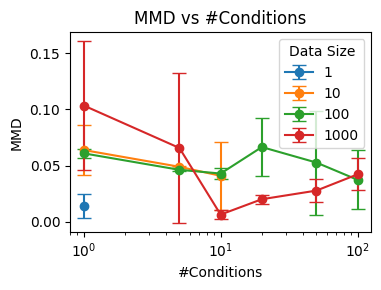

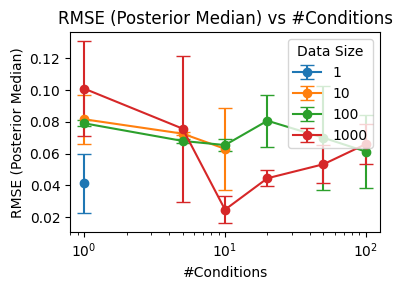

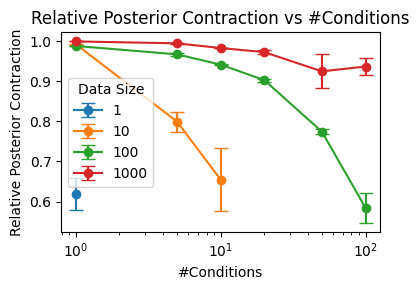

In [39]:
# ------------------------------
# Plot 2: Errorbar plots for MMD, RMSE, and Contraction vs. mini batch size.
# ------------------------------

# Filter rows with a current_number_of_obs value (skip full-batch rows).
df_mb = df_results_conditions[df_results_conditions['current_number_of_obs'].notnull()].copy()
# Convert mini_batch to float (if not already) to allow proper plotting on the x-axis.
df_mb['current_number_of_obs'] = df_mb['current_number_of_obs'].astype(float)

# Define the metrics to plot: key is dataframe column, value is label for y-axis.
metrics = {
    'mmd': 'MMD',
    'median_rmse': 'RMSE (Posterior Median)',
    'rel_contraction': 'Relative Posterior Contraction'
}

# Identify the unique data sizes (to plot different lines per data size).
unique_data_sizes = sorted(df_mb['data_size'].unique())

# Create one figure per metric.
for metric, metric_label in metrics.items():
    plt.figure(figsize=(4, 3), tight_layout=True)
    for ds in unique_data_sizes:
        # Select the rows for this particular data size.
        df_sub = df_mb[df_mb['data_size'] == ds]
        # Group by current_number_of_obs size to get mean and std of the metric.
        grouped = df_sub.groupby('current_number_of_obs')[metric].agg(['mean', 'std']).reset_index()
        plt.errorbar(grouped['current_number_of_obs'], grouped['mean'], yerr=grouped['std'],
                     marker='o', capsize=5, label=f'{ds}')
    plt.xlabel('#Conditions')
    plt.ylabel(metric_label)
    plt.title(f'{metric_label} vs #Conditions')
    plt.legend(title='Data Size')
    # Using a logarithmic scale for the x-axis since mini-batch sizes vary widely.
    plt.xscale('log')
    plt.show()

# Contraction

In [ ]:
# plot contraction factor
prior_std = prior.scale
likelihood_std = prior.simulator.scale

# contraction =  1 - posterior_var / prior_var
contractions = [posterior_contraction(prior_std, likelihood_std, n).mean() for n in range(1, 101)]
plt.figure(figsize=(5, 3), tight_layout=True)
plt.plot(contractions)
plt.title('Analytical Posterior Contraction')
plt.xlabel('Observations')
plt.ylabel('Factor')
plt.show()